In [120]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, GRU, Dense, Dropout

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os
import itertools

# RMSE and R^2 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score


from itertools import product

In [267]:
full_dataset = pd.read_csv("/Users/ms/Desktop/Stats 170a/Stats 170 Market Hotness/Datasets/NewTransactionData.csv")
market_hotness = pd.read_csv("/Users/ms/Desktop/Stats 170a/Stats 170 Market Hotness/Datasets/hotness_index_full2.csv", low_memory=False)

In [176]:
# Engagement features for July–Dec 2024.

# Contains views and Favs for all 53 counties
views_dataset = pd.read_csv("viewsFavs.csv")

views_dataset.shape # (427, 6)

FileNotFoundError: [Errno 2] No such file or directory: 'viewsFavs.csv'

In [177]:
old_market_hotness = pd.read_csv("hotness_index_full.csv", low_memory=False)

FileNotFoundError: [Errno 2] No such file or directory: 'hotness_index_full.csv'

In [268]:
filtered_full_dataset = full_dataset[full_dataset['closeprice'] > 5000]
filtered_full_dataset = filtered_full_dataset.sort_values(by=['cntycd', 'Year', 'Month'])
# filtered_full_dataset.head(12)
# filtered_full_dataset.describe()

In [269]:
# # Group by Year, Month, and cntycd and calculate multiple stats
complete_data = filtered_full_dataset.groupby(['Year', 'Month', 'cntycd']).agg({
    'buildingareatotal' : ['mean', 'median', 'count'],
    'closeprice': ['mean', 'median', 'count'],
    'cumulativedaysonmarket': ['mean', 'median', 'count'],
    'yearbuilt': ['mean', 'median', 'count'],
    'property_tax': ['mean', 'median', 'count'],
    'hpi': ['mean', 'median', 'count'],
    'CPI': ['mean', 'median', 'count'],
    'Total.Revenues': ['mean', 'median', 'count'],
    'Estimated.Population':  ['mean', 'median', 'count'],
    'Revenues.Per.Capita': ['mean', 'median', 'count'],
}).reset_index()

complete_data.columns = [
    f"{col[0]}_{col[1]}" if col[1] else col[0]
    for col in complete_data.columns.to_flat_index()
]


# List of base variables to apply the logic to
variables = [
    'buildingareatotal', 'closeprice', 'cumulativedaysonmarket', 'yearbuilt','property_tax',
    'hpi', 'CPI', 'Total.Revenues', 'Estimated.Population', 'Revenues.Per.Capita'
]

# Apply logic: if count < 10 use median, else use mean
for var in variables:
    mean_col = f"{var}_mean"
    median_col = f"{var}_median"
    count_col = f"{var}_count"
    final_col = f"{var}_final"
    
    complete_data[final_col] = complete_data.apply(
        lambda row: row[median_col] if row[count_col] < 10 else row[mean_col],
        axis=1
    )

columns_to_keep = ['Year', 'Month', 'cntycd'] + [f"{var}_final" for var in variables]
final_data = complete_data[columns_to_keep]

final_data = final_data.sort_values(by=['cntycd', 'Year', 'Month'])
final_data.head(12)


# Count the number of unique (Year, Month) per county
county_month_counts = final_data.groupby('cntycd')[['Year', 'Month']].nunique()
# print(county_month_counts)

# Calculate total months per county
county_month_counts['total_months'] = final_data.groupby('cntycd').size()
print(county_month_counts)

# Filter counties that have more than or equal to 60 months
complete_counties = county_month_counts[county_month_counts['total_months'] >= 59].reset_index()
incomplete_counties = county_month_counts[county_month_counts['total_months'] < 60].reset_index()


complete_counties_list = complete_counties['cntycd'].tolist()

# Include only the counties where we have complete data
#filtered_final_data = final_data[
#    (final_data['cntycd'].isin(complete_counties_list)) &
#    ~( (final_data['Year'] == 2020) & (final_data['Month'] == 1) ) &
#    (final_data['Year'] != 2025)
#]


#filtered_final_data.isna().sum()
#num_unique_counties = filtered_final_data['cntycd'].nunique()
#print(num_unique_counties)

final_data.isna().sum()
num_unique_counties = final_data['cntycd'].nunique()
print(num_unique_counties)

final_data.columns


        Year  Month  total_months
cntycd                           
6001       6     12            63
6003       1      1             1
6005       5     12            33
6007       6     12            62
6009       6     12            46
6011       5     11            19
6013       6     12            63
6015       1      2             2
6017       6     12            53
6019       6     12            61
6021       6     12            61
6023       4      7            10
6025       6     12            61
6027       2      2             2
6029       6     12            62
6031       6     12            54
6033       6     12            62
6035       5      8            10
6037       6     12            63
6039       6     12            62
6041       6     12            54
6043       6     12            61
6045       5     12            46
6047       6     12            62
6049       2      2             2
6051       5      9            13
6053       6     12            62
6055       6  

Index(['Year', 'Month', 'cntycd', 'buildingareatotal_final',
       'closeprice_final', 'cumulativedaysonmarket_final', 'yearbuilt_final',
       'property_tax_final', 'hpi_final', 'CPI_final', 'Total.Revenues_final',
       'Estimated.Population_final', 'Revenues.Per.Capita_final'],
      dtype='object')

In [125]:
# ONLY RUN THIS IF YOU WANT TO SEE WHICH COMBONATION OF YEAR, MONTH, and COUNTY is MISSING.

# Define your expected years and months
years = [2020, 2021, 2022, 2023, 2024]
months_per_year = {
    2020: list(range(2, 13)),  # Feb–Dec
    2021: list(range(1, 13)),
    2022: list(range(1, 13)),
    2023: list(range(1, 13)),
    2024: list(range(1, 13))
}

# Get unique counties from full_dataset
all_counties = filtered_full_dataset['cntycd'].unique()

# Build full set of expected combinations
expected_combinations = []
for year in years:
    for month in months_per_year[year]:
        for cntycd in all_counties:
            expected_combinations.append((year, month, cntycd))

expected_df = pd.DataFrame(expected_combinations, columns=['Year', 'Month', 'cntycd'])

# Merge with indicator
merged_check = expected_df.merge(
    filtered_final_data[['Year', 'Month', 'cntycd']],
    on=['Year', 'Month', 'cntycd'],
    how='left',
    indicator=True
)

# Extract only missing combinations
missing_combinations = merged_check[merged_check['_merge'] == 'left_only']

missing_summary = missing_combinations.groupby('cntycd')[['Year', 'Month']].count()
missing_summary_sorted = missing_summary.sort_values(by='Year', ascending=True)
print(missing_summary_sorted)


        Year  Month
cntycd             
6107       1      1
6061       1      1
6003      59     59
6109      59     59
6105      59     59
6101      59     59
6097      59     59
6093      59     59
6089      59     59
6063      59     59
6057      59     59
6055      59     59
6113      59     59
6051      59     59
6045      59     59
6041      59     59
6035      59     59
6031      59     59
6027      59     59
6023      59     59
6017      59     59
6015      59     59
6011      59     59
6009      59     59
6005      59     59
6049      59     59
6115      59     59


In [185]:
market_hotness.isnull().sum() # 20 no NA values, 57 counties, 3363 rows if aggregated by year, month and county
# old_market_hotness.isnull().sum() # 16 columns has NA values, 56 counties, 2570 rows if aggregated by year, month and county
market_hotness_ordered = market_hotness.sort_values(by=['cntycd', 'Year', 'Month'])
old_market_hotness_ordered = old_market_hotness.sort_values(by=['cntycd', 'Year', 'Month'])

NameError: name 'old_market_hotness' is not defined

In [270]:
market_hotness.head(10) 
num_counties = market_hotness['cntycd'].nunique()
print(f"Number of unique counties: {num_counties}")

# 57 counties

# market_hotness.describe()

# Earliest day is Feb 2020
# Latest day is December 2024

# Train 80% Test 20%
# Train: Feb 2020 - Sept 2024
# Test: Oct 2024 - Dec 2024

# LA County: 6037
# Orange County: 6059
# Riverside: 6065
# Sacramento: 6067
# San Bernardino: 6071
# San Diego: 6073
# San Francisco: 6075
# Santa Barbara: 6083
# Santa Clara: 6085
# Santa Cruz: 6087
# Ventura: 6111


market_hotness_ordered = market_hotness.sort_values(by=['cntycd', 'Year', 'Month'])

market_hotness_ordered.describe()


Number of unique counties: 57


,cntycd,Year,Month,med_dom,avg_salelistratio,n,prior_salelistratio,prior_dom,prior_absorption_rate,absorption_rate,weight,adj_avg_salelistratio,adj_med_dom,adj_absorption_rate,scaled_salelistratio,scaled_dom,scaled_absorption,raw_hotness,hotness_index
count,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000
mean,6057.421053,2022.033898,6.593220,21.213946,6.740588,961.292001,5.364810,44.684211,0.148779,0.299433,0.493210,1.048893,39.889939,0.205894,0.354877,0.111276,0.205894,0.672048,47.630783
std,33.489696,1.401976,3.405979,29.950441,96.267536,2704.408897,13.325141,21.755555,0.210578,0.223856,0.389726,0.175672,19.924162,0.196426,0.660013,0.497340,0.196426,1.267809,26.993889
min,6001.000000,2020.000000,1.000000,0.000000,0.000000,0.000000,0.950000,10.000000,0.000000,0.000000,0.000000,0.875780,5.158562,0.000000,-0.965579,-1.139555,0.000000,-1.565005,0.000000
25%,6029.000000,2021.000000,4.000000,6.000000,0.909071,3.000000,0.950000,16.000000,0.000000,0.000000,0.090909,0.950000,19.938580,0.000000,-0.151895,-0.390704,0.000000,-0.542600,21.768799
50%,6057.000000,2022.000000,7.000000,13.000000,0.979768,27.000000,0.950000,60.000000,0.000000,0.384615,0.473684,0.963855,44.347826,0.154483,0.000000,0.000000,0.154483,0.176043,37.069968
75%,6085.000000,2023.000000,10.000000,26.000000,1.017307,328.000000,1.252955,60.000000,0.436720,0.465510,0.916200,1.041215,60.000000,0.408393,0.848105,0.609296,0.408393,1.903541,73.851451
max,6115.000000,2024.000000,12.000000,359.000000,3401.206407,22184.000000,75.531984,60.000000,0.461629,0.944444,0.998650,1.500000,90.000000,0.735585,1.500000,0.978230,0.735585,3.131647,100.000000


In [271]:
# Group by county and year, then count the number of records per year
monthly_counts = market_hotness.groupby(['cntycd', 'Year'])['Month'].count().reset_index()
monthly_counts = monthly_counts.rename(columns={'Month': 'Month_Count'})

# Expected counts
expected_counts = {
    2020: 11,
    2021: 12,
    2022: 12,
    2023: 12,
    2024: 12
}

# Filter counties where each year has the expected number of months
valid_counts = monthly_counts[monthly_counts['Year'].isin(expected_counts.keys())]

# Check which counties have matching month counts for all years
complete_data = (
    valid_counts
    .groupby('cntycd')
    .apply(lambda df: all(df.set_index('Year')['Month_Count'].to_dict().get(year, 0) == count for year, count in expected_counts.items()))
    .reset_index(name='Complete')
)


# Filter only counties with complete data
complete_counties = complete_data[complete_data['Complete']]['cntycd'].tolist()


print(complete_counties)
print("Counties with complete data:", len(complete_counties))


[6001, 6003, 6005, 6007, 6009, 6011, 6013, 6015, 6017, 6019, 6021, 6023, 6025, 6027, 6029, 6031, 6033, 6035, 6037, 6039, 6041, 6043, 6045, 6047, 6049, 6051, 6053, 6055, 6057, 6059, 6061, 6063, 6065, 6067, 6069, 6071, 6073, 6075, 6077, 6079, 6081, 6083, 6085, 6087, 6089, 6093, 6095, 6097, 6099, 6101, 6103, 6105, 6107, 6109, 6111, 6113, 6115]
Counties with complete data: 57


/var/folders/nm/xwwf3vc92g3dnw28cscb1t0w0000gn/T/ipykernel_48219/2651209705.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: all(df.set_index('Year')['Month_Count'].to_dict().get(year, 0) == count for year, count in expected_counts.items()))


In [212]:
# LA County: 6037

la_county_df = market_hotness_ordered[market_hotness_ordered['cntycd'] == 6037]
print(la_county_df['Year'].value_counts().sort_index())

# Has 59 rows (all months from Feb 2020 - Dec 2024)

Year
2020    11
2021    12
2022    12
2023    12
2024    12
Name: count, dtype: int64


In [213]:
# Orange County: 6059

orange_county_df = market_hotness_ordered[market_hotness_ordered['cntycd'] == 6059]
print(orange_county_df['Year'].value_counts().sort_index())

# Has 59 rows (all months from Feb 2020 - Dec 2024)

Year
2020    11
2021    12
2022    12
2023    12
2024    12
Name: count, dtype: int64


In [214]:
# Riverside: 6065

riverside_county_df = market_hotness_ordered[market_hotness_ordered['cntycd'] == 6065]
print(riverside_county_df['Year'].value_counts().sort_index())

# Has 59 rows (all months from Feb 2020 - Dec 2024)

Year
2020    11
2021    12
2022    12
2023    12
2024    12
Name: count, dtype: int64


In [215]:
# Sacramento: 6067

sac_county_df = market_hotness_ordered[market_hotness_ordered['cntycd'] == 6067]
print(sac_county_df['Year'].value_counts().sort_index())

# Has 59 rows (all months from Feb 2020 - Dec 2024)

Year
2020    11
2021    12
2022    12
2023    12
2024    12
Name: count, dtype: int64


In [133]:
# San Bernardino: 6071

sanBern_county_df = market_hotness_ordered[market_hotness_ordered['cntycd'] == 6071]
print(sanBern_county_df['Year'].value_counts().sort_index())

# Has 59 rows (all months from Feb 2020 - Dec 2024)

Year
2020    11
2021    12
2022    12
2023    12
2024    12
Name: count, dtype: int64


In [134]:
# San Diego: 6073

sanDiego_county_df = market_hotness_ordered[market_hotness_ordered['cntycd'] == 6073]
print(sanDiego_county_df['Year'].value_counts().sort_index())

# Has 59 rows (all months from Feb 2020 - Dec 2024)

Year
2020    11
2021    12
2022    12
2023    12
2024    12
Name: count, dtype: int64


In [135]:
# San Francisco: 6075

sanFran_county_df = market_hotness_ordered[market_hotness_ordered['cntycd'] == 6075]
print(sanFran_county_df['Year'].value_counts().sort_index())

# Has 59 rows (all months from Feb 2020 - Dec 2024)

Year
2020    11
2021    12
2022    12
2023    12
2024    12
Name: count, dtype: int64


In [136]:
# Santa Barbara: 6083


santaBarbara_county_df = market_hotness_ordered[market_hotness_ordered['cntycd'] == 6083]
print(santaBarbara_county_df['Year'].value_counts().sort_index())

# Has 59 rows (all months from Feb 2020 - Dec 2024)

Year
2020    11
2021    12
2022    12
2023    12
2024    12
Name: count, dtype: int64


In [137]:
# Santa Clara: 6085

santaClara_county_df = market_hotness_ordered[market_hotness_ordered['cntycd'] == 6085]
print(santaClara_county_df['Year'].value_counts().sort_index())

# Has 59 rows (all months from Feb 2020 - Dec 2024)

Year
2020    11
2021    12
2022    12
2023    12
2024    12
Name: count, dtype: int64


In [138]:
# Santa Cruz: 6087

santaCruz_county_df = market_hotness_ordered[market_hotness_ordered['cntycd'] == 6087]
print(santaCruz_county_df['Year'].value_counts().sort_index())

# Has 59 rows (all months from Feb 2020 - Dec 2024)

Year
2020    11
2021    12
2022    12
2023    12
2024    12
Name: count, dtype: int64


In [139]:
# Ventura: 6111

ventura_county_df = market_hotness_ordered[market_hotness_ordered['cntycd'] == 6111]
print(ventura_county_df['Year'].value_counts().sort_index())

# Has 59 rows (all months from Feb 2020 - Dec 2024)

Year
2020    11
2021    12
2022    12
2023    12
2024    12
Name: count, dtype: int64


In [272]:
final_data.head()




,Year,Month,cntycd,buildingareatotal_final,closeprice_final,cumulativedaysonmarket_final,yearbuilt_final,property_tax_final,hpi_final,CPI_final,Total.Revenues_final,Estimated.Population_final,Revenues.Per.Capita_final
0,2020,1,6001,1501.593254,1.028756e+06,19.027778,1959.079365,779769928.0,669.41,273.340,3.752905e+09,1670834.0,2246.0
39,2020,2,6001,1595.482900,1.077905e+06,21.038356,1960.229711,779769928.0,669.41,274.412,3.752905e+09,1670834.0,2246.0
81,2020,3,6001,1576.610787,1.004900e+06,27.900875,1955.064327,779769928.0,669.41,273.995,3.752905e+09,1670834.0,2246.0
123,2020,4,6001,1491.442922,9.991801e+05,26.538813,1954.676876,779769928.0,677.08,272.913,3.752905e+09,1670834.0,2246.0
161,2020,5,6001,1689.356873,1.126185e+06,24.290038,1951.112232,779769928.0,677.08,273.062,3.752905e+09,1670834.0,2246.0


In [273]:
# LA County: 6037
# Orange County: 6059
# Riverside: 6065
# San Bernardino: 6071
# San Diego: 6073
# Ventura: 6111



counties_with_full_data = market_hotness_ordered[market_hotness_ordered['cntycd'].isin(complete_counties)].copy()
# print(counties_with_full_data)

print(final_data.columns)

print(counties_with_full_data.columns)

# Step 1: Combine 2020–2024 and 2025 data
combined_df = pd.concat([counties_with_full_data, final_data[final_data['Year'] == 2025]], ignore_index=True)

# Step 2: Sort so shift() works correctly
combined_df = combined_df.sort_values(['cntycd', 'Year', 'Month']).reset_index(drop=True)

# Step 3: Generate lag features on this combined_df
for col in ['hotness_index', 'med_dom', 'avg_salelistratio', 'prior_salelistratio', 'prior_dom', 
            'buildingareatotal_final', 'closeprice_final', 'cumulativedaysonmarket_final', 'yearbuilt_final',
            'property_tax_final', 'hpi_final', 'CPI_final', 'Total.Revenues_final',
            'Estimated.Population_final', 'Revenues.Per.Capita_final']:
    combined_df[f'{col}_lag_1'] = combined_df.groupby('cntycd')[col].shift(1)
    combined_df[f'{col}_lag_3'] = combined_df.groupby('cntycd')[col].shift(3)

# Step 4: (optional) Fill lags with backfill for earliest months
lag_cols = [col for col in combined_df.columns if 'lag' in col]
combined_df[lag_cols] = combined_df[lag_cols].fillna(method='bfill')

# Step 5: If you only want 2025 rows for prediction
df_2025 = combined_df[combined_df['Year'] == 2025].copy()






Index(['Year', 'Month', 'cntycd', 'buildingareatotal_final',
       'closeprice_final', 'cumulativedaysonmarket_final', 'yearbuilt_final',
       'property_tax_final', 'hpi_final', 'CPI_final', 'Total.Revenues_final',
       'Estimated.Population_final', 'Revenues.Per.Capita_final'],
      dtype='object')
Index(['cntycd', 'Year', 'Month', 'med_dom', 'avg_salelistratio', 'n',
       'prior_salelistratio', 'prior_dom', 'prior_absorption_rate',
       'absorption_rate', 'weight', 'adj_avg_salelistratio', 'adj_med_dom',
       'adj_absorption_rate', 'date', 'scaled_salelistratio', 'scaled_dom',
       'scaled_absorption', 'raw_hotness', 'hotness_index'],
      dtype='object')


/var/folders/nm/xwwf3vc92g3dnw28cscb1t0w0000gn/T/ipykernel_48219/2044468712.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df[lag_cols] = combined_df[lag_cols].fillna(method='bfill')


In [279]:
combined_df[(combined_df['Year'] == 2025)][
    ['Year', 'Month', 'cntycd', 'hotness_index', 'hotness_index_lag_1', 'hotness_index_lag_3', 'med_dom', 'med_dom_lag_1', 'med_dom_lag_3',
                 'avg_salelistratio', 'avg_salelistratio_lag_1', 'avg_salelistratio_lag_3']
]

combined_df[combined_df['Year'] == 2025].head()


,cntycd,Year,Month,med_dom,avg_salelistratio,n,prior_salelistratio,prior_dom,prior_absorption_rate,absorption_rate,weight,adj_avg_salelistratio,adj_med_dom,adj_absorption_rate,date,scaled_salelistratio,scaled_dom,scaled_absorption,raw_hotness,hotness_index,buildingareatotal_final,closeprice_final,cumulativedaysonmarket_final,yearbuilt_final,property_tax_final,hpi_final,CPI_final,Total.Revenues_final,Estimated.Population_final,Revenues.Per.Capita_final,hotness_index_lag_1,hotness_index_lag_3,med_dom_lag_1,med_dom_lag_3,avg_salelistratio_lag_1,avg_salelistratio_lag_3,prior_salelistratio_lag_1,prior_salelistratio_lag_3,prior_dom_lag_1,prior_dom_lag_3,buildingareatotal_final_lag_1,buildingareatotal_final_lag_3,closeprice_final_lag_1,closeprice_final_lag_3,cumulativedaysonmarket_final_lag_1,cumulativedaysonmarket_final_lag_3,yearbuilt_final_lag_1,yearbuilt_final_lag_3,property_tax_final_lag_1,property_tax_final_lag_3,hpi_final_lag_1,hpi_final_lag_3,CPI_final_lag_1,CPI_final_lag_3,Total.Revenues_final_lag_1,Total.Revenues_final_lag_3,Estimated.Population_final_lag_1,Estimated.Population_final_lag_3,Revenues.Per.Capita_final_lag_1,Revenues.Per.Capita_final_lag_3
59,6001,2025,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1663.346282,1.274875e+06,13.044893,1966.245283,931217054.0,967.68,335.989,NaN,NaN,NaN,71.014720,68.971511,12.0,15.0,1.038874,1.046040,1.240659,1.240659,13.0,13.0,1663.346282,NaN,1.274875e+06,NaN,13.044893,NaN,1966.245283,NaN,931217054.0,NaN,967.68,NaN,335.989,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,6001,2025,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1812.803191,1.385723e+06,9.895604,1958.888298,931217054.0,967.68,337.868,NaN,NaN,NaN,21.768799,72.431685,0.0,15.0,0.000000,1.055267,0.950000,1.240659,60.0,13.0,1663.346282,NaN,1.274875e+06,NaN,13.044893,NaN,1966.245283,NaN,931217054.0,NaN,967.68,NaN,335.989,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,6001,2025,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1283.000000,8.795000e+05,0.000000,1947.000000,931217054.0,967.68,NaN,NaN,NaN,NaN,21.768799,71.014720,0.0,12.0,0.000000,1.038874,0.950000,1.240659,60.0,13.0,1812.803191,NaN,1.385723e+06,NaN,9.895604,NaN,1958.888298,NaN,931217054.0,NaN,967.68,NaN,337.868,NaN,NaN,NaN,NaN,NaN,NaN,NaN
239,6007,2025,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8492.080392,3.331784e+05,42.088235,1988.520548,33881028.0,967.68,335.989,NaN,NaN,NaN,85.393514,67.411294,10.0,17.0,34.470736,0.982307,1.617070,1.617070,13.0,13.0,8492.080392,NaN,3.331784e+05,NaN,42.088235,NaN,1988.520548,NaN,33881028.0,NaN,967.68,NaN,335.989,NaN,NaN,NaN,NaN,NaN,NaN,NaN
240,6007,2025,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7640.127273,2.377727e+05,31.909091,1962.000000,33881028.0,967.68,337.868,NaN,NaN,NaN,17.964148,80.855958,88.0,7.0,0.508475,0.992492,0.950000,1.617070,60.0,13.0,8492.080392,NaN,3.331784e+05,NaN,42.088235,NaN,1988.520548,NaN,33881028.0,NaN,967.68,NaN,335.989,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [280]:
combined_df.head()

combined_df.to_csv("final_datafile.csv", index=False)

In [249]:
# Step 1: Define columns to lag
lag_columns = [
    'buildingareatotal_final',
    'closeprice_final',
    'cumulativedaysonmarket_final',
    'yearbuilt_final',
    'property_tax_final',
    'hpi_final',
    'CPI_final'
]

# Step 2: Generate lag_1 and lag_3
for col in lag_columns:
    combined_df[f'{col}_lag_1'] = (
        combined_df.groupby('cntycd')[col].shift(1)
    )
    combined_df[f'{col}_lag_3'] = (
        combined_df.groupby('cntycd')[col].shift(3)
    )

# Step 3: Fill missing lag values using backward fill (bfill)
for col in lag_columns:
    combined_df[f'{col}_lag_1'] = combined_df[f'{col}_lag_1'].fillna(method='bfill')
    combined_df[f'{col}_lag_3'] = combined_df[f'{col}_lag_3'].fillna(method='bfill')


/var/folders/nm/xwwf3vc92g3dnw28cscb1t0w0000gn/T/ipykernel_48219/3550392583.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df[f'{col}_lag_1'] = combined_df[f'{col}_lag_1'].fillna(method='bfill')
/var/folders/nm/xwwf3vc92g3dnw28cscb1t0w0000gn/T/ipykernel_48219/3550392583.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df[f'{col}_lag_3'] = combined_df[f'{col}_lag_3'].fillna(method='bfill')


In [253]:
combined_df.head()

,cntycd,Year,Month,med_dom,avg_salelistratio,n,prior_salelistratio,prior_dom,prior_absorption_rate,absorption_rate,weight,adj_avg_salelistratio,adj_med_dom,adj_absorption_rate,date,scaled_salelistratio,scaled_dom,scaled_absorption,raw_hotness,hotness_index,buildingareatotal_final,closeprice_final,cumulativedaysonmarket_final,yearbuilt_final,property_tax_final,hpi_final,CPI_final,Total.Revenues_final,Estimated.Population_final,Revenues.Per.Capita_final,buildingareatotal_final_lag_1,closeprice_final_lag_1,cumulativedaysonmarket_final_lag_1,yearbuilt_final_lag_1,property_tax_final_lag_1,hpi_final_lag_1,CPI_final_lag_1,hotness_index_lag_3,hotness_index_lag_1,med_dom_lag_1,med_dom_lag_3,avg_salelistratio_lag_1,avg_salelistratio_lag_3,prior_salelistratio_lag_1,prior_salelistratio_lag_3,prior_dom_lag_1,prior_dom_lag_3,buildingareatotal_final_lag_3,closeprice_final_lag_3,cumulativedaysonmarket_final_lag_3,yearbuilt_final_lag_3,property_tax_final_lag_3,hpi_final_lag_3,CPI_final_lag_3
0,6001,2020,2,12.0,1.109423,755.0,1.240659,13.0,0.457198,0.032934,0.961783,1.114439,12.038217,0.049148,2020-02-01,1.500000,0.806502,0.049148,2.355650,83.477645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1663.346282,1.274875e+06,13.044893,1966.245283,931217054.0,967.68,335.989,83.477645,83.477645,12.0,12.0,1.109423,1.109423,1.240659,1.240659,13.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6001,2020,3,13.0,1.050983,717.0,1.240659,13.0,0.457198,0.341564,0.959839,1.058601,13.000000,0.346208,2020-03-01,1.038707,0.782494,0.346208,2.167409,79.469662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1663.346282,1.274875e+06,13.044893,1966.245283,931217054.0,967.68,335.989,83.477645,83.477645,12.0,12.0,1.109423,1.109423,1.240659,1.240659,13.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6001,2020,4,15.0,1.018582,664.0,1.240659,13.0,0.457198,0.456212,0.956772,1.028182,14.913545,0.456254,2020-04-01,0.705220,0.734729,0.456254,1.896203,73.695216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1663.346282,1.274875e+06,13.044893,1966.245283,931217054.0,967.68,335.989,83.477645,79.469662,13.0,12.0,1.050983,1.109423,1.240659,1.240659,13.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6001,2020,5,13.0,1.041108,799.0,1.240659,13.0,0.457198,0.353846,0.963812,1.048330,13.000000,0.357586,2020-05-01,0.926105,0.782494,0.357586,2.066186,77.314437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1663.346282,1.274875e+06,13.044893,1966.245283,931217054.0,967.68,335.989,83.477645,73.695216,15.0,12.0,1.018582,1.109423,1.240659,1.240659,13.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6001,2020,6,12.0,1.059627,1078.0,1.240659,13.0,0.457198,0.391008,0.972924,1.064529,12.027076,0.392800,2020-06-01,1.103699,0.806780,0.392800,2.303279,82.362572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1663.346282,1.274875e+06,13.044893,1966.245283,931217054.0,967.68,335.989,79.469662,77.314437,13.0,13.0,1.041108,1.050983,1.240659,1.240659,13.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## IGNORE THIS BLOCK DONT NEED

In [ ]:
group_sizes = counties_with_full_data.groupby('cntycd')[['Year', 'Month']].size()

# print(counties_with_full_data.shape) 

# New (3363, 20)
# Old (1770, 16) 
# print(counties_with_full_data.columns.tolist())
# print(group_sizes)
# 59

missing_rows = counties_with_full_data[counties_with_full_data['hotness_index'].isnull()]
# print(missing_rows)



counties_with_full_data['hotness_index_lag_1'] = (
    counties_with_full_data
    .groupby('cntycd')['hotness_index']
    .shift(1)
)

counties_with_full_data['med_dom_lag_1'] = (
    counties_with_full_data
    .groupby('cntycd')['med_dom']
    .shift(1)
)

counties_with_full_data['avg_salelistratio_lag_1'] = (
    counties_with_full_data
    .groupby('cntycd')['avg_salelistratio']
    .shift(1)
)

counties_with_full_data['prior_salelistratio_lag_1'] = (
    counties_with_full_data
    .groupby('cntycd')['prior_salelistratio']
    .shift(1)
)

counties_with_full_data['prior_dom_lag_1'] = (
    counties_with_full_data
    .groupby('cntycd')['prior_dom']
    .shift(1)
)

counties_with_full_data['hotness_index_lag_3'] = (
    counties_with_full_data
    .groupby('cntycd')['hotness_index']
    .shift(3)
)

counties_with_full_data['med_dom_lag_3'] = (
    counties_with_full_data
    .groupby('cntycd')['med_dom']
    .shift(3)
)

counties_with_full_data['avg_salelistratio_lag_3'] = (
    counties_with_full_data
    .groupby('cntycd')['avg_salelistratio']
    .shift(3)
)

counties_with_full_data['prior_salelistratio_lag_3'] = (
    counties_with_full_data
    .groupby('cntycd')['prior_salelistratio']
    .shift(3)
)

counties_with_full_data['prior_dom_lag_3'] = (
    counties_with_full_data
    .groupby('cntycd')['prior_dom']
    .shift(3)
)



# The issue is that lag doesn't have a value for Feb 2020
# So we use a backward fill method

counties_with_full_data['hotness_index_lag_1'] = counties_with_full_data['hotness_index_lag_1'].fillna(method='bfill')
counties_with_full_data['med_dom_lag_1'] = counties_with_full_data['med_dom_lag_1'].fillna(method='bfill')
counties_with_full_data['avg_salelistratio_lag_1'] = counties_with_full_data['avg_salelistratio_lag_1'].fillna(method='bfill')
counties_with_full_data['prior_salelistratio_lag_1'] = counties_with_full_data['prior_salelistratio_lag_1'].fillna(method='bfill')
counties_with_full_data['prior_dom_lag_1'] = counties_with_full_data['prior_dom_lag_1'].fillna(method='bfill')


counties_with_full_data['hotness_index_lag_3'] = counties_with_full_data['hotness_index_lag_3'].fillna(method='bfill')
counties_with_full_data['med_dom_lag_3'] = counties_with_full_data['med_dom_lag_3'].fillna(method='bfill')
counties_with_full_data['avg_salelistratio_lag_3'] = counties_with_full_data['avg_salelistratio_lag_3'].fillna(method='bfill')
counties_with_full_data['prior_salelistratio_lag_3'] = counties_with_full_data['prior_salelistratio_lag_3'].fillna(method='bfill')
counties_with_full_data['prior_dom_lag_3'] = counties_with_full_data['prior_dom_lag_3'].fillna(method='bfill')

# counties_with_full_data.head(10)

counties_with_full_data.isnull().sum()

# print(counties_with_full_data.isnull().sum().sort_values(ascending=False))

### Resume

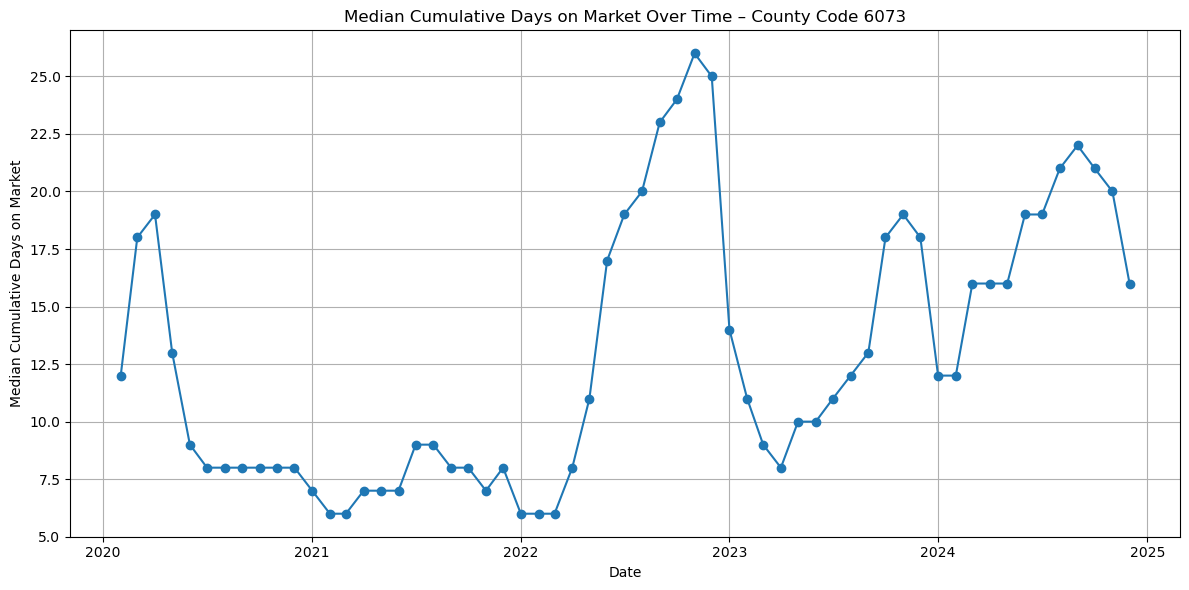

In [246]:
# Choose a specific county — e.g., Los Angeles County (6037)
county_code = 6073  # Change to any of the others (6059, 6065, etc.)

# Filter the DataFrame
county_df = counties_with_full_data[counties_with_full_data['cntycd'] == county_code].copy()

# Create a datetime column from year and month for plotting
county_df['year_month'] = pd.to_datetime(county_df[['Year', 'Month']].assign(day=1))

# Sort by date
county_df = county_df.sort_values('year_month')

# Plot
plt.figure(figsize=(12, 6))
plt.plot(county_df['year_month'], county_df['med_dom'], marker='o')
plt.title(f"Median Cumulative Days on Market Over Time – County Code {county_code}")
plt.xlabel("Date")
plt.ylabel("Median Cumulative Days on Market")
plt.grid(True)
plt.tight_layout()
plt.show()

In [239]:
counties_with_full_data.head()

,cntycd,Year,Month,med_dom,avg_salelistratio,n,prior_salelistratio,prior_dom,prior_absorption_rate,absorption_rate,weight,adj_avg_salelistratio,adj_med_dom,adj_absorption_rate,date,scaled_salelistratio,scaled_dom,scaled_absorption,raw_hotness,hotness_index
0,6001,2020,2,12.0,1.109423,755,1.240659,13,0.457198,0.032934,0.961783,1.114439,12.038217,0.049148,2020-02-01,1.500000,0.806502,0.049148,2.355650,83.477645
1,6001,2020,3,13.0,1.050983,717,1.240659,13,0.457198,0.341564,0.959839,1.058601,13.000000,0.346208,2020-03-01,1.038707,0.782494,0.346208,2.167409,79.469662
2,6001,2020,4,15.0,1.018582,664,1.240659,13,0.457198,0.456212,0.956772,1.028182,14.913545,0.456254,2020-04-01,0.705220,0.734729,0.456254,1.896203,73.695216
3,6001,2020,5,13.0,1.041108,799,1.240659,13,0.457198,0.353846,0.963812,1.048330,13.000000,0.357586,2020-05-01,0.926105,0.782494,0.357586,2.066186,77.314437
4,6001,2020,6,12.0,1.059627,1078,1.240659,13,0.457198,0.391008,0.972924,1.064529,12.027076,0.392800,2020-06-01,1.103699,0.806780,0.392800,2.303279,82.362572


In [240]:
final_data.head()

,Year,Month,cntycd,buildingareatotal_final,closeprice_final,cumulativedaysonmarket_final,yearbuilt_final,property_tax_final,hpi_final,CPI_final,Total.Revenues_final,Estimated.Population_final,Revenues.Per.Capita_final,buildingareatotal_final_lag_1,closeprice_final_lag_1,cumulativedaysonmarket_final_lag_1,yearbuilt_final_lag_1,property_tax_final_lag_1,hpi_final_lag_1,CPI_final_lag_1,hotness_index_lag_3
0,2020,1,6001,1501.593254,1.028756e+06,19.027778,1959.079365,779769928.0,669.41,273.340,3.752905e+09,1670834.0,2246.0,1501.593254,1.028756e+06,19.027778,1959.079365,779769928.0,669.41,273.340,NaN
39,2020,2,6001,1595.482900,1.077905e+06,21.038356,1960.229711,779769928.0,669.41,274.412,3.752905e+09,1670834.0,2246.0,1501.593254,1.028756e+06,19.027778,1959.079365,779769928.0,669.41,273.340,82.712311
81,2020,3,6001,1576.610787,1.004900e+06,27.900875,1955.064327,779769928.0,669.41,273.995,3.752905e+09,1670834.0,2246.0,1595.482900,1.077905e+06,21.038356,1960.229711,779769928.0,669.41,274.412,21.768799
123,2020,4,6001,1491.442922,9.991801e+05,26.538813,1954.676876,779769928.0,677.08,272.913,3.752905e+09,1670834.0,2246.0,1576.610787,1.004900e+06,27.900875,1955.064327,779769928.0,669.41,273.995,21.768799
161,2020,5,6001,1689.356873,1.126185e+06,24.290038,1951.112232,779769928.0,677.08,273.062,3.752905e+09,1670834.0,2246.0,1491.442922,9.991801e+05,26.538813,1954.676876,779769928.0,677.08,272.913,22.523950


In [251]:
merged_data = pd.merge(
    #filtered_final_data,
    combined_df,
    final_data,
    on=['cntycd', 'Year', 'Month'],
    how='left'
)

In [252]:
merged_data.head()

,cntycd,Year,Month,med_dom,avg_salelistratio,n,prior_salelistratio,prior_dom,prior_absorption_rate,absorption_rate,weight,adj_avg_salelistratio,adj_med_dom,adj_absorption_rate,date,scaled_salelistratio,scaled_dom,scaled_absorption,raw_hotness,hotness_index,buildingareatotal_final_x,closeprice_final_x,cumulativedaysonmarket_final_x,yearbuilt_final_x,property_tax_final_x,hpi_final_x,CPI_final_x,Total.Revenues_final_x,Estimated.Population_final_x,Revenues.Per.Capita_final_x,buildingareatotal_final_lag_1_x,closeprice_final_lag_1_x,cumulativedaysonmarket_final_lag_1_x,yearbuilt_final_lag_1_x,property_tax_final_lag_1_x,hpi_final_lag_1_x,CPI_final_lag_1_x,hotness_index_lag_3_x,hotness_index_lag_1,med_dom_lag_1,med_dom_lag_3,avg_salelistratio_lag_1,avg_salelistratio_lag_3,prior_salelistratio_lag_1,prior_salelistratio_lag_3,prior_dom_lag_1,prior_dom_lag_3,buildingareatotal_final_lag_3,closeprice_final_lag_3,cumulativedaysonmarket_final_lag_3,yearbuilt_final_lag_3,property_tax_final_lag_3,hpi_final_lag_3,CPI_final_lag_3,buildingareatotal_final_y,closeprice_final_y,cumulativedaysonmarket_final_y,yearbuilt_final_y,property_tax_final_y,hpi_final_y,CPI_final_y,Total.Revenues_final_y,Estimated.Population_final_y,Revenues.Per.Capita_final_y,buildingareatotal_final_lag_1_y,closeprice_final_lag_1_y,cumulativedaysonmarket_final_lag_1_y,yearbuilt_final_lag_1_y,property_tax_final_lag_1_y,hpi_final_lag_1_y,CPI_final_lag_1_y,hotness_index_lag_3_y
0,6001,2020,2,12.0,1.109423,755.0,1.240659,13.0,0.457198,0.032934,0.961783,1.114439,12.038217,0.049148,2020-02-01,1.500000,0.806502,0.049148,2.355650,83.477645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1663.346282,1.274875e+06,13.044893,1966.245283,931217054.0,967.68,335.989,83.477645,83.477645,12.0,12.0,1.109423,1.109423,1.240659,1.240659,13.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1595.482900,1.077905e+06,21.038356,1960.229711,779769928.0,669.41,274.412,3.752905e+09,1670834.0,2246.0,1501.593254,1.028756e+06,19.027778,1959.079365,779769928.0,669.41,273.340,82.712311
1,6001,2020,3,13.0,1.050983,717.0,1.240659,13.0,0.457198,0.341564,0.959839,1.058601,13.000000,0.346208,2020-03-01,1.038707,0.782494,0.346208,2.167409,79.469662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1663.346282,1.274875e+06,13.044893,1966.245283,931217054.0,967.68,335.989,83.477645,83.477645,12.0,12.0,1.109423,1.109423,1.240659,1.240659,13.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1576.610787,1.004900e+06,27.900875,1955.064327,779769928.0,669.41,273.995,3.752905e+09,1670834.0,2246.0,1595.482900,1.077905e+06,21.038356,1960.229711,779769928.0,669.41,274.412,21.768799
2,6001,2020,4,15.0,1.018582,664.0,1.240659,13.0,0.457198,0.456212,0.956772,1.028182,14.913545,0.456254,2020-04-01,0.705220,0.734729,0.456254,1.896203,73.695216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1663.346282,1.274875e+06,13.044893,1966.245283,931217054.0,967.68,335.989,83.477645,79.469662,13.0,12.0,1.050983,1.109423,1.240659,1.240659,13.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1491.442922,9.991801e+05,26.538813,1954.676876,779769928.0,677.08,272.913,3.752905e+09,1670834.0,2246.0,1576.610787,1.004900e+06,27.900875,1955.064327,779769928.0,669.41,273.995,21.768799
3,6001,2020,5,13.0,1.041108,799.0,1.240659,13.0,0.457198,0.353846,0.963812,1.048330,13.000000,0.357586,2020-05-01,0.926105,0.782494,0.357586,2.066186,77.314437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1663.346282,1.274875e+06,13.044893,1966.245283,931217054.0,967.68,335.989,83.477645,73.695216,15.0,12.0,1.018582,1.109423,1.240659,1.240659,13.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1689.356873,1.126185e+06,24.290038,1951.112232,779769928.0,677.08,273.062,3.752905e+09,1670834.0,2246.0,1491.442922,9.991801e+05,26.538813,1954.676876,779769928.0,677.08,272.913,22.523950
4,6001,2020,6,12.0,1.059627,1078.0,1.240659,13.0,0.457198,0.391008,0.972924,1.064529,12.027076,0.392800,2020-06-01,1.103699,0.806780,0.392800,2.303279,82.362572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1663.346282,1.274875e+06,13.044893,1966.245283,931217054.0,967.68,335.989,79.469662,77.

In [ ]:




merged_data['buildingareatotal_final_lag_1'] = (
    merged_data
    .groupby('cntycd')['buildingareatotal_final']
    .shift(1)
)

merged_data['closeprice_final_lag_1'] = (
    merged_data
    .groupby('cntycd')['closeprice_final']
    .shift(1)
)

merged_data['cumulativedaysonmarket_final_lag_1'] = (
    merged_data
    .groupby('cntycd')['cumulativedaysonmarket_final']
    .shift(1)
)

merged_data['yearbuilt_final_lag_1'] = (
    merged_data
    .groupby('cntycd')['yearbuilt_final']
    .shift(1)
)

merged_data['property_tax_final_lag_1'] = (
    merged_data
    .groupby('cntycd')['property_tax_final']
    .shift(1)
)

merged_data['hpi_final_lag_1'] = (
    merged_data
    .groupby('cntycd')['hpi_final']
    .shift(1)
)

merged_data['CPI_final_lag_1'] = (
    merged_data
    .groupby('cntycd')['CPI_final']
    .shift(1)
)

# The issue is that lag doesn't have a value for Feb 2020
# So we use a backward fill method

merged_data['buildingareatotal_final_lag_1'] = merged_data['buildingareatotal_final_lag_1'].fillna(method='bfill')
merged_data['closeprice_final_lag_1'] = merged_data['closeprice_final_lag_1'].fillna(method='bfill')
merged_data['cumulativedaysonmarket_final_lag_1'] = merged_data['cumulativedaysonmarket_final_lag_1'].fillna(method='bfill')
merged_data['yearbuilt_final_lag_1'] = merged_data['yearbuilt_final_lag_1'].fillna(method='bfill')
merged_data['property_tax_final_lag_1'] = merged_data['property_tax_final_lag_1'].fillna(method='bfill')
merged_data['hpi_final_lag_1'] = merged_data['hpi_final_lag_1'].fillna(method='bfill')
merged_data['CPI_final_lag_1'] = merged_data['CPI_final_lag_1'].fillna(method='bfill')


########################################################

merged_data['hotness_index_lag_3'] = (
    merged_data
    .groupby('cntycd')['hotness_index']
    .shift(3)
)

merged_data['med_dom_lag_3'] = (
    merged_data
    .groupby('cntycd')['med_dom']
    .shift(3)
)

merged_data['avg_salelistratio_lag_3'] = (
    merged_data
    .groupby('cntycd')['avg_salelistratio']
    .shift(3)
)

merged_data['buildingareatotal_final_lag_3'] = (
    merged_data
    .groupby('cntycd')['buildingareatotal_final']
    .shift(3)
)

merged_data['closeprice_final_lag_3'] = (
    merged_data
    .groupby('cntycd')['closeprice_final']
    .shift(3)
)

merged_data['cumulativedaysonmarket_final_lag_3'] = (
    merged_data
    .groupby('cntycd')['cumulativedaysonmarket_final']
    .shift(3)
)

merged_data['yearbuilt_final_lag_3'] = (
    merged_data
    .groupby('cntycd')['yearbuilt_final']
    .shift(3)
)

merged_data['property_tax_final_lag_3'] = (
    merged_data
    .groupby('cntycd')['property_tax_final']
    .shift(3)
)

merged_data['hpi_final_lag_3'] = (
    merged_data
    .groupby('cntycd')['hpi_final']
    .shift(3)
)

merged_data['CPI_final_lag_3'] = (
    merged_data
    .groupby('cntycd')['CPI_final']
    .shift(3)
)

merged_data['buildingareatotal_final_lag_3'] = merged_data['buildingareatotal_final_lag_3'].fillna(method='bfill')
merged_data['closeprice_final_lag_3'] = merged_data['closeprice_final_lag_3'].fillna(method='bfill')
merged_data['cumulativedaysonmarket_final_lag_3'] = merged_data['cumulativedaysonmarket_final_lag_3'].fillna(method='bfill')
merged_data['yearbuilt_final_lag_3'] = merged_data['yearbuilt_final_lag_3'].fillna(method='bfill')
merged_data['property_tax_final_lag_3'] = merged_data['property_tax_final_lag_3'].fillna(method='bfill')
merged_data['hpi_final_lag_3'] = merged_data['hpi_final_lag_3'].fillna(method='bfill')
merged_data['CPI_final_lag_3'] = merged_data['CPI_final_lag_3'].fillna(method='bfill')

/var/folders/nm/xwwf3vc92g3dnw28cscb1t0w0000gn/T/ipykernel_48219/284621973.py:54: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data['buildingareatotal_final_lag_1'] = merged_data['buildingareatotal_final_lag_1'].fillna(method='bfill')
/var/folders/nm/xwwf3vc92g3dnw28cscb1t0w0000gn/T/ipykernel_48219/284621973.py:55: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data['closeprice_final_lag_1'] = merged_data['closeprice_final_lag_1'].fillna(method='bfill')
/var/folders/nm/xwwf3vc92g3dnw28cscb1t0w0000gn/T/ipykernel_48219/284621973.py:56: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data['cumulativedaysonmarket_final_lag_1'] = merged_data['cumulativedaysonmarket_final_lag_1'].fillna(method='bfill')
/var/fol

In [242]:
merged_data[merged_data['Year']==2025].head(10)



,Year,Month,cntycd,buildingareatotal_final,closeprice_final,cumulativedaysonmarket_final,yearbuilt_final,property_tax_final,hpi_final,CPI_final,Total.Revenues_final,Estimated.Population_final,Revenues.Per.Capita_final,buildingareatotal_final_lag_1,closeprice_final_lag_1,cumulativedaysonmarket_final_lag_1,yearbuilt_final_lag_1,property_tax_final_lag_1,hpi_final_lag_1,CPI_final_lag_1,hotness_index_lag_3,med_dom,avg_salelistratio,n,prior_salelistratio,prior_dom,prior_absorption_rate,absorption_rate,weight,adj_avg_salelistratio,adj_med_dom,adj_absorption_rate,date,scaled_salelistratio,scaled_dom,scaled_absorption,raw_hotness,hotness_index,med_dom_lag_3,avg_salelistratio_lag_3,buildingareatotal_final_lag_3,closeprice_final_lag_3,cumulativedaysonmarket_final_lag_3,yearbuilt_final_lag_3,property_tax_final_lag_3,hpi_final_lag_3,CPI_final_lag_3
60,2025,1,6001,1663.346282,1.274875e+06,13.044893,1966.245283,931217054.0,967.68,335.989,NaN,NaN,NaN,1619.360396,1.181290e+06,16.909639,1966.039604,980913558.0,967.81,334.084,68.971511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,1.046040,1636.187534,1.230784e+06,24.742128,1962.035831,980913558.0,967.81,334.558
61,2025,2,6001,1812.803191,1.385723e+06,9.895604,1958.888298,931217054.0,967.68,337.868,NaN,NaN,NaN,1663.346282,1.274875e+06,13.044893,1966.245283,931217054.0,967.68,335.989,72.431685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,1.055267,1635.827434,1.195255e+06,22.206538,1964.307692,980913558.0,967.81,334.218
62,2025,3,6001,1283.000000,8.795000e+05,0.000000,1947.000000,931217054.0,967.68,NaN,NaN,NaN,NaN,1812.803191,1.385723e+06,9.895604,1958.888298,931217054.0,967.68,337.868,71.014720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,1.038874,1619.360396,1.181290e+06,16.909639,1966.039604,980913558.0,967.81,334.084
157,2025,1,6007,8492.080392,3.331784e+05,42.088235,1988.520548,33881028.0,967.68,335.989,NaN,NaN,NaN,4425.354839,3.747774e+05,19.215054,1976.275000,35279430.0,967.81,334.084,67.411294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,0.982307,14876.330035,3.811169e+05,37.901060,1980.288618,35279430.0,967.81,334.558
158,2025,2,6007,7640.127273,2.377727e+05,31.909091,1962.000000,33881028.0,967.68,337.868,NaN,NaN,NaN,8492.080392,3.331784e+05,42.088235,1988.520548,33881028.0,967.68,335.989,80.855958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,0.992492,8475.139459,3.855464e+05,17.362162,1982.973856,35279430.0,967.81,334.218
204,2025,1,6009,2098.000000,4.850000e+05,34.000000,1987.000000,10910103.0,967.68,335.989,NaN,NaN,NaN,1452.000000,3.900000e+05,72.000000,2004.000000,10297033.0,967.81,334.218,20.053205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,0.880936,2118.500000,6.155000e+05,45.000000,1990.000000,10297033.0,963.92,334.265
284,2025,1,6013,1731.512289,9.930222e+05,13.198157,1972.598462,426331721.0,967.68,335.989,NaN,NaN,NaN,1857.527100,9.436952e+05,18.434426,1978.099320,416730583.0,967.81,334.084,80.482467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,1.071493,1805.479459,1.033907e+06,25.320445,1974.857350,416730583.0,967.81,334.558
285,2025,2,6013,1865.425000,1.266366e+06,6.591667,1975.300000,426331721.0,967.68,337.868,NaN,NaN,NaN,1731.512289,9.930222e+05,13.198157,1972.598462,426331721.0,967.68,335.989,80.096010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,0.996974,2585.924928,9.633910e+05,25.151107,1977.426230,416730583.0,967.81,334.218
286,2025,3,6013,2091.000000,1.277143e+06,0.000000,1979.000000,426331721.0,967.68,NaN,NaN,NaN,NaN,1865.425000,1.266366e+06,6.591667,1975.300000,426331721.0,967.68,337.868,81.237483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,1.010079,1857.527100,9.436952e+05,18.434426,1978.099320,416730583.0,967.81,334.084
341,2025,1,6017,25541.500000,3.357500e+05,13.000000,1995.000000,26391047.0,967.68,335.989,NaN,NaN,Na

In [243]:
merged_data[merged_data['Year']==2025].shape

(76, 47)

In [244]:
merged_data_with_views = pd.merge(
    merged_data,
    views_dataset[['cntycd', 'Year', 'Month', 'total_views', 'total_favs']],
    on=['cntycd', 'Year', 'Month'],
    how='left'
)

merged_data_with_views['total_views'] = merged_data_with_views['total_views'].fillna(0)
merged_data_with_views['total_favs'] = merged_data_with_views['total_favs'].fillna(0)

merged_data_with_views['log_views'] = np.log1p(merged_data_with_views['total_views'])
merged_data_with_views['log_favs'] = np.log1p(merged_data_with_views['total_favs'])


merged_data_with_views['log_views_lag_3'] = (
    merged_data_with_views
    .groupby('cntycd')['log_views']
    .shift(3)
)

merged_data_with_views['log_favs_lag_3'] = (
    merged_data_with_views
    .groupby('cntycd')['log_favs']
    .shift(3)
)


merged_data_with_views['log_favs_lag_3'] = merged_data_with_views['log_favs_lag_3'].fillna(method='bfill')
merged_data_with_views['log_views_lag_3'] = merged_data_with_views['log_views_lag_3'].fillna(method='bfill')

merged_data_with_views['has_engagement'] = ((merged_data_with_views['log_views_lag_3'] > 0) | (merged_data_with_views['log_views_lag_3'] > 0)).astype(int)


print(merged_data_with_views.isna().sum().loc[lambda x: x > 0])
merged_data_with_views.tail(12)


NameError: name 'views_dataset' is not defined

In [ ]:
# Step 1: Define features and target 
features_to_include = ['prior_salelistratio_lag_3', 'prior_dom_lag_3', 'hotness_index_lag_3', 'med_dom_lag_3',
                       'avg_salelistratio_lag_3', 'buildingareatotal_final_lag_3',
                       'closeprice_final_lag_3','cumulativedaysonmarket_final_lag_3', 
                       'yearbuilt_final_lag_3', 'property_tax_final_lag_3', 
                       'hpi_final_lag_3', 'CPI_final_lag_3', 'log_views_lag_3', 'log_favs_lag_3', 'has_engagement']

num_features = len(features_to_include)

feature_cols = [col for col in merged_data_with_views.columns if col in features_to_include]

X_data = []
y_data = []
seq_length = 6  # use past 12 months to predict next month's hotness_index

# In time series forecasting (especially housing/market data), patterns like:
# Seasonality, Annual cycles, Lagged macro trends (e.g., interest rates, absorption, DOM)
# often repeat over year-long intervals.

# A 12-month lookback window helps the model:
# 1. Understand annual price cycles.
# 2. Learn temporal dependencies over a realistic timeframe.


# Scale features
scaler = MinMaxScaler()
X_raw_all = merged_data_with_views[feature_cols].values
scaler.fit(X_raw_all) 



# Step 2: Prepare sequences per county
for countyId, group in merged_data_with_views.groupby('cntycd'):
    group_sorted = group.sort_values(by=['Year', 'Month']).reset_index(drop=True)

    # Extract features and target
    X_raw = group_sorted[feature_cols].values
    y_raw = group_sorted['hotness_index'].values

    X_scaled = scaler.transform(X_raw)

    # Create sequences of length `seq_length`
    for i in range(len(X_scaled) - seq_length):
        X_seq = X_scaled[i:i+seq_length]  # shape: (seq_length, num_features)
        y_target = y_raw[i + seq_length]  # target is the hotness_index after the sequence
        X_data.append(X_seq)
        y_data.append(y_target)


# Convert to numpy arrays
X_seq_array = np.array(X_data)
y_seq_array = np.array(y_data)

split_idx = int(0.9 * len(X_seq_array))
X_train, X_test = X_seq_array[:split_idx], X_seq_array[split_idx:]
y_train, y_test = y_seq_array[:split_idx], y_seq_array[split_idx:]

In [ ]:
GRUmodel = Sequential([
    Masking(mask_value=0.0, input_shape=(seq_length, num_features)),
    GRU(64),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])



GRUmodel.compile(optimizer='adam', loss='mse', metrics=['mae'])
GRUmodel.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/50
96/96 [==============================] - 1s 5ms/step - loss: 3308.1440 - mae: 51.9005 - val_loss: 435.8602 - val_mae: 16.5898
Epoch 2/50
96/96 [==============================] - 0s 1ms/step - loss: 724.5028 - mae: 22.8753 - val_loss: 745.8074 - val_mae: 23.3850
Epoch 3/50
96/96 [==============================] - 0s 1ms/step - loss: 564.1982 - mae: 20.1081 - val_loss: 762.4120 - val_mae: 23.6356
Epoch 4/50
96/96 [==============================] - 0s 1ms/step - loss: 558.6681 - mae: 19.9044 - val_loss: 730.5853 - val_mae: 23.1503
Epoch 5/50
96/96 [==============================] - 0s 1ms/step - loss: 554.1278 - mae: 20.0213 - val_loss: 738.4464 - val_mae: 23.2722
Epoch 6/50
96/96 [==============================] - 0s 1ms/step - loss: 538.0013 - mae: 19.6332 - val_loss: 770.4001 - val_mae: 23.7568
Epoch 7/50
96/96 [==============================] - 0s 1ms/step - loss: 547.6682 - mae: 19.8661 - val_loss: 769.3989 - val_mae: 23.7590
Epoch 8/50
96/96 [=============================

In [ ]:
y_pred = GRUmodel.predict(X_test)
y_pred_list  = y_pred.flatten().tolist()

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")


6/6 [==============================] - 0s 657us/step
R²: 0.5794
RMSE: 12.79


In [ ]:
# V2
y_pred = GRUmodel.predict(X_test).flatten()

# Step 1: Create metadata list when building sequences (optional but ideal)
metadata = []

for county_id, group in merged_data.groupby('cntycd'):
    group_sorted = group.sort_values(by=['Year', 'Month']).reset_index(drop=True)
    
    for i in range(len(group_sorted) - seq_length):
        # Save metadata of the prediction target (i.e., the month after the sequence)
        row = group_sorted.iloc[i + seq_length]
        metadata.append((county_id, row['Year'], row['Month']))

# Slice metadata to match X_test size
metadata_test = metadata[split_idx:]  # if you did an 80/20 split

# Create a DataFrame to compare
results_df = pd.DataFrame(metadata_test, columns=['cntycd', 'Year', 'Month'])
results_df['actual_hotness'] = y_test
results_df['predicted_hotness'] = y_pred

# Display
print(results_df.head())

6/6 [==============================] - 0s 702us/step
   cntycd  Year  Month  actual_hotness  predicted_hotness
0    6099  2024      1       65.707262          45.600624
1    6099  2024      2       46.128811          45.549095
2    6099  2024      3       55.799039          44.468571
3    6099  2024      4       44.847399          43.924793
4    6099  2024      5       47.347495          44.975780


count    1886.000000
mean       65.898076
std        22.581872
min         0.000000
25%        46.329146
50%        69.556263
75%        86.572400
max       100.000000
Name: hotness_index, dtype: float64
Total sequences: 1694


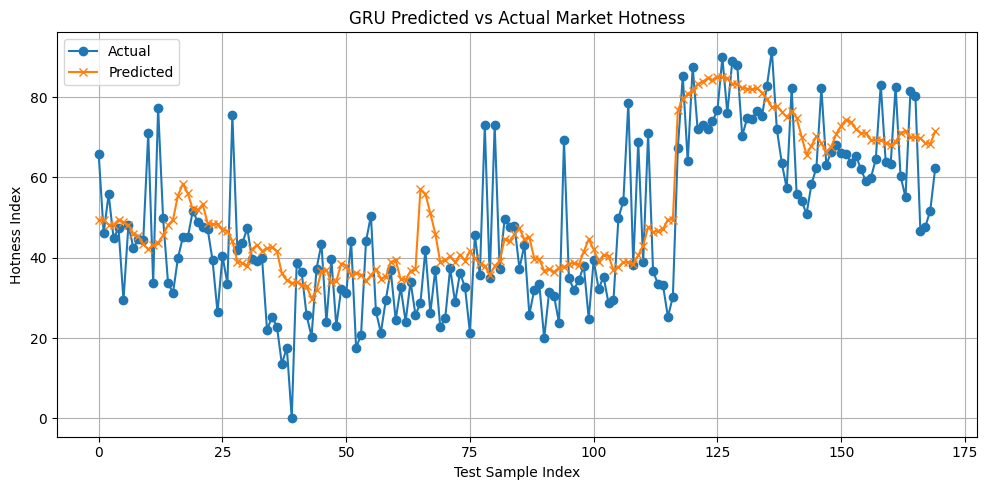

In [ ]:
print(merged_data['hotness_index'].describe())
print(f"Total sequences: {len(X_seq_array)}")

# Plot to visualize actual market_hotness index vs predicted (based on model)
plt.figure(figsize=(10,5))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.legend()
plt.title('GRU Predicted vs Actual Market Hotness')
plt.xlabel('Test Sample Index')
plt.ylabel('Hotness Index')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Forecasting Individually

# LA County: 6037
# Orange County: 6059
# Riverside: 6065
# San Bernardino: 6071
# San Diego: 6073
# Ventura: 6111

# For a specific county, say cntycd = 6037 (LA County)
target_county = 6037

# Filter and sort
county_data = merged_data_with_views[merged_data_with_views['cntycd'] == target_county]
county_data_sorted = county_data.sort_values(by=['Year', 'Month']).reset_index(drop=True)

# Get last 6 rows (July–Dec 2024)
latest_seq_df = county_data_sorted.tail(6)

# Scale it
X_latest = latest_seq_df[feature_cols].values
X_latest_scaled = scaler.transform(X_latest)

# shape = (6, num_features)

In [ ]:
def forecast_3_months(model, initial_seq, scaler, feature_cols):
    """
    Forecast hotness_index for the next 3 months recursively.

    Parameters:
    - model: your trained GRU model
    - initial_seq: last 6-month sequence (scaled), shape: (seq_length, num_features)
    - scaler: fitted MinMaxScaler used for feature scaling
    - feature_cols: list of feature column names, must include 'hotness_index_lag_3'

    Returns:
    - A list of 3 predicted hotness_index values for t+1, t+2, t+3
    """
    predictions = []
    current_seq = initial_seq.copy()

    for step in range(3):
        # Predict next month
        next_pred = model.predict(current_seq[np.newaxis, :, :])[0][0]  # extract scalar

        predictions.append(next_pred)

        # Update input sequence for next step
        new_row = current_seq[-1].copy()  # clone last row

        # Update the lag feature with new prediction (if it exists)
        if 'hotness_index_lag_3' in feature_cols:
            idx = feature_cols.index('hotness_index_lag_3')
            new_row[idx] = next_pred

        # Shift sequence: drop first, append new row
        current_seq = np.vstack([current_seq[1:], new_row])

    return predictions



forecast = forecast_3_months(
    model=GRUmodel,
    initial_seq=X_latest_scaled,
    scaler=scaler,
    feature_cols=feature_cols
)

print("Hotness Index forecast for Jan–Mar 2025:", forecast)

1/1 [==============================] - 0s 10ms/step
Hotness Index forecast for Jan–Mar 2025: [78.00416, 75.88369, 72.39841]


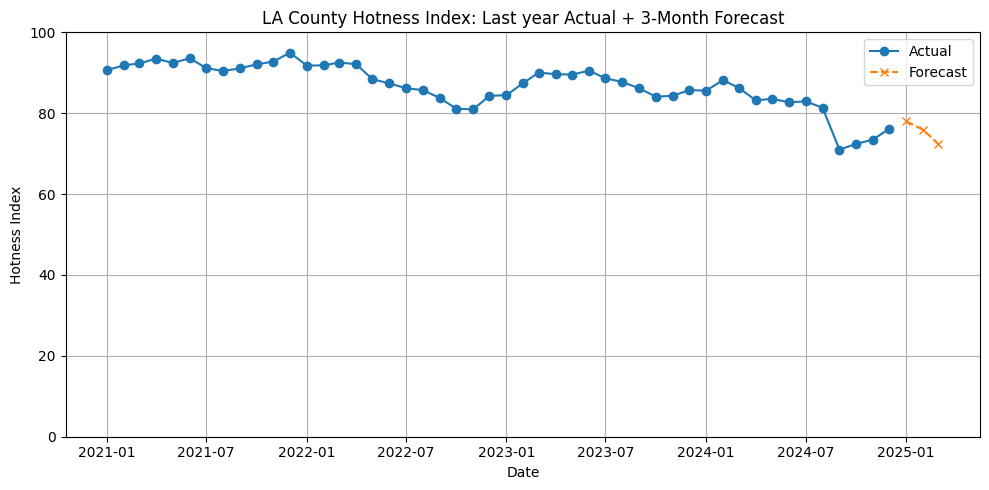

In [ ]:
# Step 1: Filter the actual values for LA County (cntycd = 6037)
la_data = merged_data[merged_data_with_views['cntycd'] == 6037].copy()
la_data['date'] = pd.to_datetime(la_data['Year'].astype(str) + '-' + la_data['Month'].astype(str) + '-01')
la_data = la_data.sort_values('date')


# Get the last 6 actual data points
actual = la_data.tail(48)

# Step 2: Create 3 future months for the forecast
actual_date = actual['date'].iloc[-1]
future_dates = pd.date_range(start=actual_date + pd.DateOffset(months=1), periods=3, freq='MS')

# Step 3: Build a combined DataFrame for plotting
actual_series = pd.Series(actual['hotness_index'].values, index=actual['date'])
forecast_series = pd.Series(forecast, index=future_dates)

# Step 4: Plot
plt.figure(figsize=(10, 5))
plt.plot(actual_series.index, actual_series.values, label='Actual', marker='o')
plt.plot(forecast_series.index, forecast_series.values, label='Forecast', marker='x', linestyle='--')

plt.title('LA County Hotness Index: Last year Actual + 3-Month Forecast')
plt.xlabel('Date')
plt.ylabel('Hotness Index')
plt.ylim(0, 100)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Run this to create for all 55 counties

# Ensure output directory exists
os.makedirs("forecast_plots", exist_ok=True)

# Loop through each county with full data
for county_id in merged_data_with_views['cntycd'].unique():
    try:
        # Step 1: Filter and sort
        county_data = merged_data_with_views[merged_data_with_views['cntycd'] == county_id]
        county_data_sorted = county_data.sort_values(by=['Year', 'Month']).reset_index(drop=True)
        
        # Ensure we have enough data
        if len(county_data_sorted) < 6:
            print(f"Skipping county {county_id}: not enough data")
            continue

        # Step 2: Get last 6 rows (e.g., July–Dec 2024)
        latest_seq_df = county_data_sorted.tail(6)
        X_latest = latest_seq_df[feature_cols].values
        X_latest_scaled = scaler.transform(X_latest)

        # Step 3: Forecast 3 months ahead
        forecast = forecast_3_months(
            model=GRUmodel,
            initial_seq=X_latest_scaled,
            scaler=scaler,
            feature_cols=feature_cols
        )

        # Step 4: Create date index
        county_data_sorted['date'] = pd.to_datetime(
            county_data_sorted['Year'].astype(str) + '-' + county_data_sorted['Month'].astype(str) + '-01'
        )
        actual_series = county_data_sorted.tail(48)[['date', 'hotness_index']].set_index('date')['hotness_index']

        last_actual_date = actual_series.index[-1]
        forecast_dates = pd.date_range(start=last_actual_date + pd.DateOffset(months=1), periods=3, freq='MS')
        forecast_series = pd.Series(forecast, index=forecast_dates)

        # Step 5: Plot
        plt.figure(figsize=(10, 5))
        plt.plot(actual_series.index, actual_series.values, label='Actual', marker='o')
        plt.plot(forecast_series.index, forecast_series.values, label='Forecast', marker='x', linestyle='--')

        plt.title(f'County {county_id} Hotness Index: Actual + 3-Month Forecast')
        plt.xlabel('Date')
        plt.ylabel('Hotness Index')
        plt.ylim(0, 100)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        # Save or show plot
        plt.savefig(f"forecast_plots/county_{county_id}_forecast.png")
        plt.close()

        print(f"✓ Forecast complete for county {county_id}")

    except Exception as e:
        print(f"⚠️ Error for county {county_id}: {e}")

1/1 [==============================] - 0s 8ms/step
✓ Forecast complete for county 6001
1/1 [==============================] - 0s 8ms/step
✓ Forecast complete for county 6007
1/1 [==============================] - 0s 10ms/step
✓ Forecast complete for county 6013
1/1 [==============================] - 0s 9ms/step
✓ Forecast complete for county 6019
1/1 [==============================] - 0s 9ms/step
✓ Forecast complete for county 6021
1/1 [==============================] - 0s 8ms/step
✓ Forecast complete for county 6025
1/1 [==============================] - 0s 8ms/step
✓ Forecast complete for county 6029
1/1 [==============================] - 0s 9ms/step
✓ Forecast complete for county 6033
1/1 [==============================] - 0s 8ms/step
✓ Forecast complete for county 6037
1/1 [==============================] - 0s 9ms/step
✓ Forecast complete for county 6039
1/1 [==============================] - 0s 8ms/step
✓ Forecast complete for county 6043
1/1 [==============================] - 0s 